In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [34]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, TruePositives, FalsePositives, FalseNegatives
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from tensorflow_addons.metrics import F1Score

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [19]:
train_dir = "../input/chest-xray-pneumonia/chest_xray/train"
test_dir = "../input/chest-xray-pneumonia/chest_xray/test"
validation_dir = "../input/chest-xray-pneumonia/chest_xray/val"


In [51]:
val_test_datagen = ImageDataGenerator(rescale = 1./255)
train_datagen = ImageDataGenerator(
            rescale = 1/255.,rotation_range = 0.3)

train_set = train_datagen.flow_from_directory(train_dir, class_mode = "binary", batch_size = 8, target_size = (224, 224))
validation_set = val_test_datagen.flow_from_directory(validation_dir, class_mode = "binary", batch_size = 8, target_size = (224, 224))
test_set = val_test_datagen.flow_from_directory(test_dir, class_mode = "binary", batch_size = 8, target_size = (224, 224))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [47]:
weights_path = '/kaggle/input/vgg16file/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

base_model1 = VGG16(
    include_top=False, weights=weights_path,
    input_shape=(224, 224, 3), pooling="max", classes=2
)

In [48]:
base_model1.summary()


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
#Model

In [52]:
model2 = Sequential()
model2.add(base_model1)
model2.add(Flatten())

model2.add(Dense(128, activation = "relu"))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(32, activation = "relu"))
model2.add(Dense(1, activation = "sigmoid"))

# freeze the layers
for layer in base_model1.layers:
    layer.trainable = False

model2.compile(optimizer = "adam", loss = "binary_crossentropy",  metrics=[
        "acc",
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc'),
        F1Score(num_classes=1, threshold=0.5, name='f1_score')
    ])

In [ ]:
history = model2.fit_generator(train_set, epochs = 15, validation_data = validation_set, steps_per_epoch = 100)

/tmp/ipykernel_47/3232769594.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model2.fit_generator(train_set, epochs = 15, validation_data = validation_set, steps_per_epoch = 100)


Epoch 1/15
100/100 [==============================] - 235s 2s/step - loss: 0.2142 - acc: 0.9150 - precision: 0.9420 - recall: 0.9451 - auc: 0.9608 - f1_score: 0.9435 - val_loss: 0.5730 - val_acc: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000 - val_auc: 0.9609 - val_f1_score: 0.8000
Epoch 2/15
100/100 [==============================] - 234s 2s/step - loss: 0.1494 - acc: 0.9575 - precision: 0.9666 - recall: 0.9764 - auc: 0.9809 - f1_score: 0.9714 - val_loss: 0.2363 - val_acc: 0.9375 - val_precision: 1.0000 - val_recall: 0.8750 - val_auc: 1.0000 - val_f1_score: 0.9333
Epoch 3/15
100/100 [==============================] - 234s 2s/step - loss: 0.1474 - acc: 0.9375 - precision: 0.9570 - recall: 0.9601 - auc: 0.9830 - f1_score: 0.9585 - val_loss: 0.8693 - val_acc: 0.6875 - val_precision: 0.6154 - val_recall: 1.0000 - val_auc: 1.0000 - val_f1_score: 0.7619
Epoch 4/15
100/100 [==============================] - 233s 2s/step - loss: 0.1689 - acc: 0.9362 - precision: 0.9598 - recall: 0.9550 

In [ ]:
#Visualize the performance of model

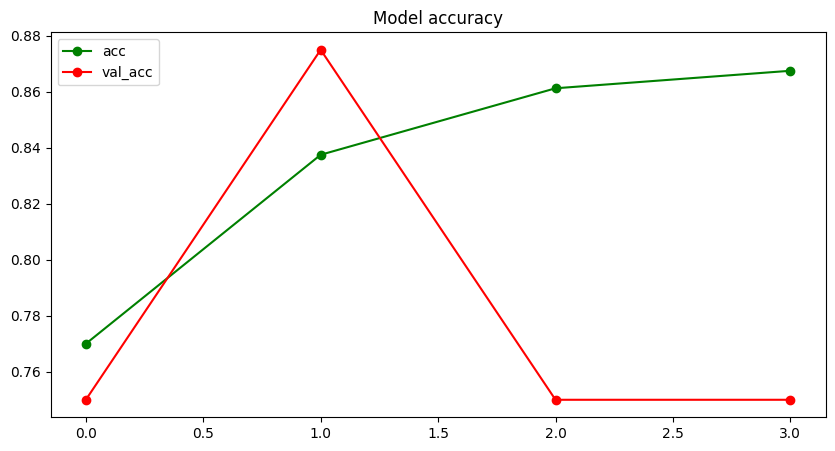

In [40]:
plt.figure(figsize = (10, 5))
plt.title("Model accuracy")
plt.plot(history.history["acc"], "go-")
plt.plot(history.history["val_acc"], "ro-")
plt.legend(["acc", "val_acc"])
plt.show()

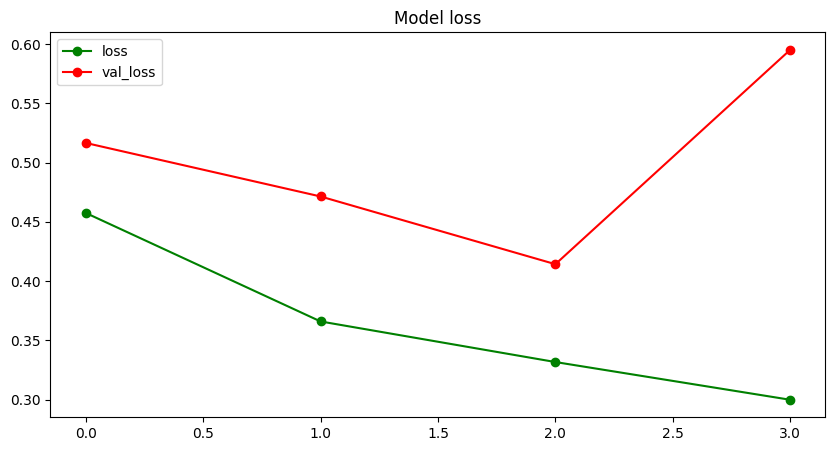

In [41]:
plt.figure(figsize = (10, 5))
plt.title("Model loss")
plt.plot(history.history["loss"], "go-")
plt.plot(history.history["val_loss"], "ro-")
plt.legend(["loss", "val_loss"])
plt.show()

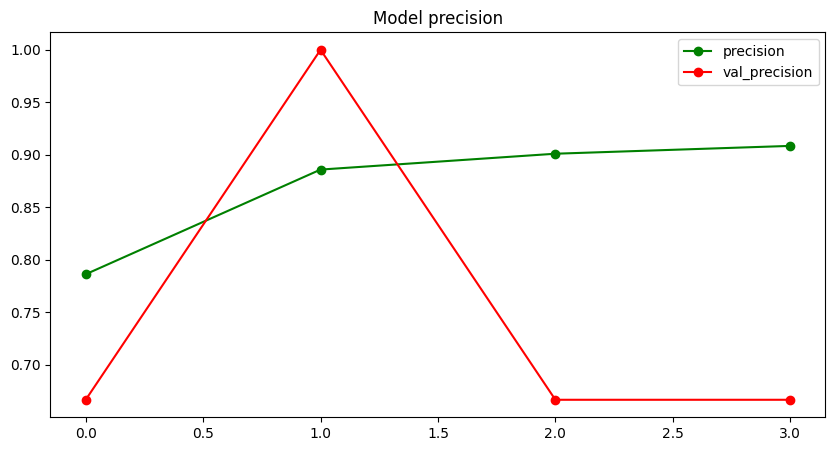

In [42]:
plt.figure(figsize = (10, 5))
plt.title("Model precision")
plt.plot(history.history["precision"], "go-")
plt.plot(history.history["val_precision"], "ro-")
plt.legend(["precision", "val_precision"])
plt.show()

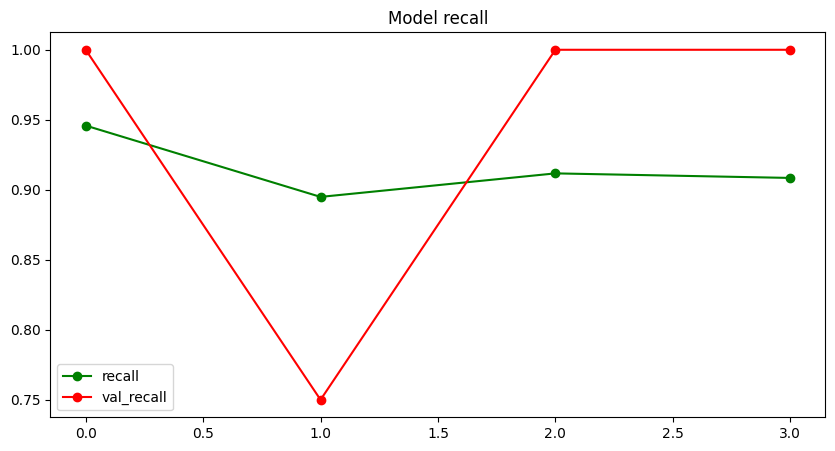

In [43]:
plt.figure(figsize = (10, 5))
plt.title("Model recall")
plt.plot(history.history["recall"], "go-")
plt.plot(history.history["val_recall"], "ro-")
plt.legend(["recall", "val_recall"])
plt.show()

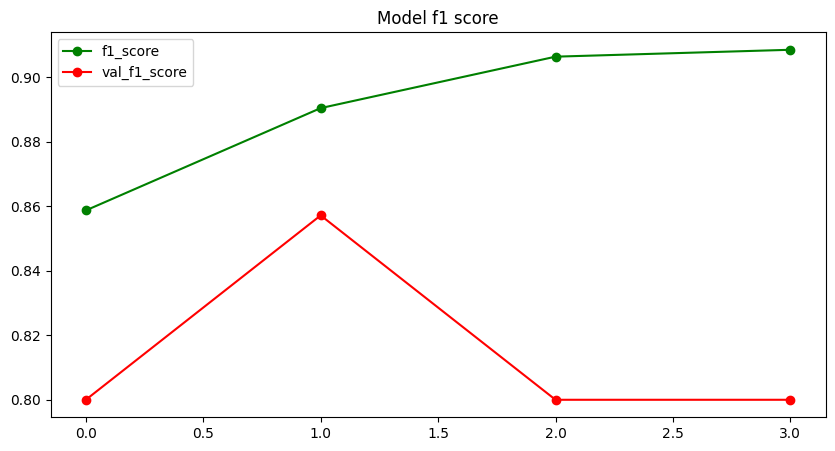

In [44]:
plt.figure(figsize = (10, 5))
plt.title("Model f1 score")
plt.plot(history.history["f1_score"], "go-")
plt.plot(history.history["val_f1_score"], "ro-")
plt.legend(["f1_score", "val_f1_score"])
plt.show()